# import

In [59]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy
import pickle
import random
import seaborn as sns
import matplotlib.colors as mcolors
from tqdm import tqdm

from itertools import groupby

# ## set ppseq file
def find_example_file(PP_PATH, example = '178_1_7'):
    for file_ in os.listdir(PP_PATH):
        if example in file_:
            file = file_
    return file 

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def merge_short_blocks(lst,threshold):
    merged_list = []
    current_block = [lst[0]]

    for i in range(1, len(lst)):
        if lst[i] == lst[i-1]:
            current_block.append(lst[i])
        else:
            if len(current_block) < threshold:
                if len(merged_list) > 0:
                    # Join with smallest adjacent block
                    if len(current_block) <= len(merged_list[-1]):
                        merged_list[-1].extend(current_block)
                    else:
                        merged_list.append(current_block + merged_list.pop())
                else:
                    # No adjacent block, discard current block
                    pass
            else:
                merged_list.append(current_block)
            
            current_block = [lst[i]]

    # Check the last block
    if len(current_block) < 3:
        if len(merged_list) > 0:
            if len(current_block) <= len(merged_list[-1]):
                merged_list[-1].extend(current_block)
            else:
                merged_list.append(current_block + merged_list.pop())
        else:
            pass
    else:
        merged_list.append(current_block)
        
    out = []
    for item in merged_list:
        out += [item[0]] * len(item)
        

    return out

def relabel_list(lst):
    # Create a dictionary to map original values to new labels
    label_dict = {}
    new_label = 1

    # Iterate over the list and assign new labels
    relabeled_list = []
    for value in lst:
        if value not in label_dict:
            label_dict[value] = new_label
            new_label += 1
        relabeled_list.append(label_dict[value])

    return relabeled_list


def most_common(lst):
    return max(set(lst), key=lst.count)

def extract_hyperdataset_details(runs_dataset):
    # Here we can see the params available in the dataset
    for key_here in runs_dataset[1][0]["params"]:
        if key_here != 'warp_type':
            params = [dataset[0]["params"][key_here] for dataset in runs_dataset]
            if len(np.unique(params)) > 1:
                print(f"{key_here}, {np.unique(params)}")
                
    # (Number of threads just controls how many threads are going on in the computation, i.e. doesn't change the model!)
    swept_params = ["Conc Param", "Seq Event Factor", "Neuron Offset Pseudo Obvs", "Fudge Factor", "Num Sequence Types"]
    chosen_params = [0.6, 1.0, 0.5, 0.1, 6]
    mean_event_proportionality = 234.41132467

    dataset_details = np.zeros([len(runs_dataset), 8])
    chosen_indices = []
    averaging_window = 50
    cutoff_likelihood = 6
    params_check = ["neuron_response_conc_param", "seq_event_rate", "neuron_offset_pseudo_obs", "mean_event_amplitude", "num_sequence_types"]



    for (dataset_id, dataset) in enumerate(runs_dataset):
        test_likelihoods = []
        for repeat in range(len(dataset)):
            if np.mean(dataset[repeat]["test_log_p"].to_numpy()[-averaging_window:]) > cutoff_likelihood:
                test_likelihoods.append(dataset[repeat]["test_log_p"].to_numpy()[-averaging_window:])
                dataset_details[dataset_id,7] += 1
            
        dataset_details[dataset_id,5] = np.mean(test_likelihoods)
        stds_per_t = np.zeros([averaging_window])
        for t in range(averaging_window):
            stds_per_t[t] = np.std([test_likelihoods[i][t] for i in range(len(test_likelihoods))])
        dataset_details[dataset_id,6] = np.mean(stds_per_t)
            
        params = [np.round(dataset[repeat]["params"][i],10) for i in params_check]    
        params[3] = np.round(params[3]/mean_event_proportionality, 3)
        params[1] = 5*params[1]/params[4]
        params = np.array(params)
        dataset_details[dataset_id,:5] = params
        

    cleaned_dataset_details = np.zeros(dataset_details.shape)
    counter = 0
    for dataset_detail in dataset_details:
        if np.logical_not(np.isnan(dataset_detail[5])):
            cleaned_dataset_details[counter, :] = dataset_detail
            
            if np.sum(dataset_detail[:5] == chosen_params) == 5:
                chosen_indices.append(counter)
            
            counter += 1
    dataset_details = cleaned_dataset_details[:counter,:]
    
    return dataset_details


def add_arrows(i, this_param_vals, means_here, stds_here):
    if i == 0:
        arrow_x = 6
    elif i == 1:
        arrow_x = 0
    elif i == 2:
        arrow_x = -1.2
    elif i == 3:
        arrow_x = 0
    elif i == 4:
        arrow_x = -0.7
    else:
        return

    # find nearest data point
    x_vals = np.log(this_param_vals) if i > 0 else this_param_vals
    nearest_idx = np.argmin(np.abs(x_vals - arrow_x))
    arrow_y = means_here[nearest_idx]

    # draw arrow with FIXED visual length
    plt.annotate(
        '',
        xy=(arrow_x, arrow_y),            # arrow tip
        xytext=(0, 20),                    # arrow base offset (20 points upward)
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='red', lw=1)
    )



In [60]:

# Get the current working directory
current_working_dir = os.getcwd()
current_working_dir = '//'.join(current_working_dir.split('\\')[0:-1]) + r'//data/f3//'

# figure B

neuron_response_conc_param, [  0.1   0.6   1.    1.6   3.   10.  100. ]
seq_event_rate, [ 0.08  0.1   0.12  0.14  0.4   0.5   0.6   0.7   0.8   1.    1.2   1.4
  4.    5.    6.    7.   40.   50.   60.   70.  ]
neuron_offset_pseudo_obs, [ 0.5  1.   5.  10. ]
num_threads, [ 6 10]
mean_event_amplitude, [ 11.72056623  23.44113247  70.3233974  234.41132467]
num_sequence_types, [4 5 6 7]
var_event_amplitude, [ 117.20566234  234.41132467  703.23397402 2344.11324673]


c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Histogram with KDE Curve')

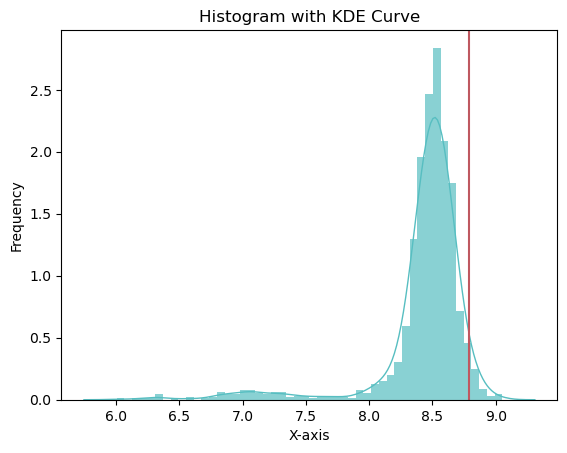

In [3]:
file = open(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED4\Hyperparam_Results", 'rb')

# dump information to that file
runs_dataset = pickle.load(file)

dataset_details = extract_hyperdataset_details(runs_dataset)

data = dataset_details[:,5]

# Step 1: Create the histogram
hist, bins, _ = plt.hist(data, bins=50, density=True, alpha=0.7, color='#57BEC1', label='Histogram')

# Step 2: Use seaborn's KDE to create the curve that approximates the histogram
sns.kdeplot(data, color='#57BEC1', linewidth=1, label='KDE Curve')

# plot he chosen models log p
plt.axvline(8.791226339279392,c='#BF5860')

plt.xlabel('X-axis')
plt.ylabel('Frequency')
plt.title('Histogram with KDE Curve')

# figure C

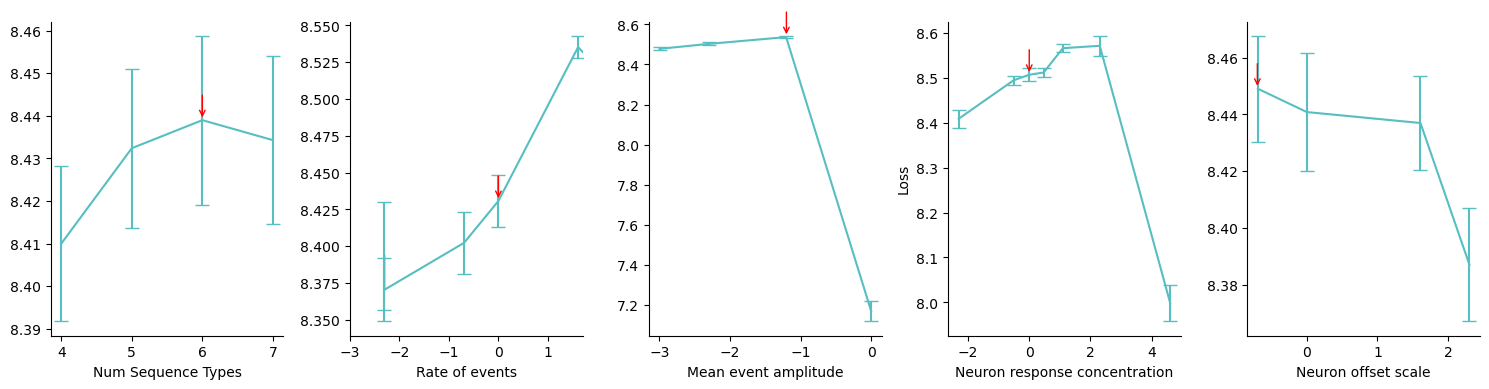

In [58]:
plt.figure(figsize = (15,4))
swept_params = ["Neuron response concentration", "Rate of events", "Neuron offset scale", "Mean event amplitude", "Num Sequence Types"]
to_log = [True, True, True, True, False]
for i,param_choice in enumerate(np.array([4,1,3,0,2])):
    this_param_vals = np.unique(dataset_details[:,param_choice])
    
    means_here = np.zeros([len(this_param_vals)])
    stds_here = np.zeros([len(this_param_vals)])

    for param_setting in range(len(this_param_vals)):
        means_here[param_setting] = np.mean(dataset_details[dataset_details[:,param_choice] == this_param_vals[param_setting], 5])
        stds_here[param_setting] = np.std(dataset_details[dataset_details[:,param_choice] == this_param_vals[param_setting], 5])
        # Convert from standard deviation to standard error on the mean, by dividing by root(n)
        stds_here[param_setting] = stds_here[param_setting]/np.sqrt(np.sum(dataset_details[:,param_choice] == this_param_vals[param_setting]))
    
    plt.subplot(1, 5,i+1)
    if i == 0: # (dont log the first hperparam value - doesnt make snese to)
        plt.errorbar(this_param_vals, means_here, yerr=stds_here, color = '#57BEC1', capsize=5)
        add_arrows(i,this_param_vals,means_here,stds_here)
    else:
        plt.errorbar(np.log(this_param_vals), means_here, yerr=stds_here, color= '#57BEC1', capsize=5)
        add_arrows(i,this_param_vals,means_here,stds_here)
        if i == 1:
            plt.xlim(-3,1.7)
            
    ax = plt.gca()
    ax.spines['right'].set_visible(False)   # remove left line
    ax.spines['top'].set_visible(False)   # remove left line

    plt.xlabel(swept_params[param_choice])
    if param_choice == 0:
        plt.ylabel('Loss')
        
plt.tight_layout()




# figure D

Text(0, 0.5, 'Log p')

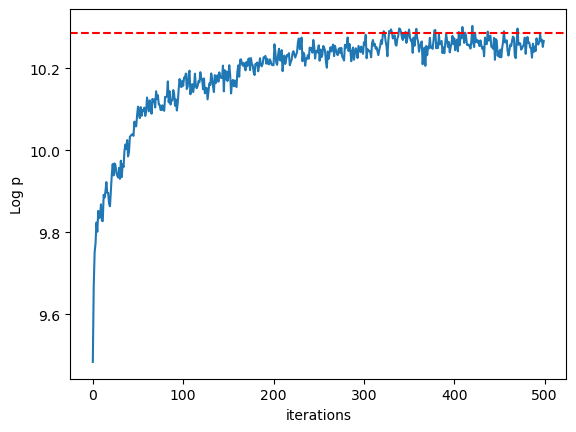

In [ ]:
def plot_log_l_curve(log_p_hist_df):
    # find 95% of growth value and when it crossed this
    max_ = max(log_p_hist_df.x1)
    min_ = min(log_p_hist_df.x1)
    growth = max_ - min_
    _prcntile =  max_ - (0.02 * growth)

    ## model log likley hood curve
    plt.plot(log_p_hist_df.x1)
    plt.axhline(y=_prcntile, color='r', linestyle='--')

# load data 
example_log_p_hist_df = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED4\example_log_p_hist_df.csv")

plot_log_l_curve(example_log_p_hist_df)
plt.xlabel('iterations')
plt.ylabel('Log p')

# figure E

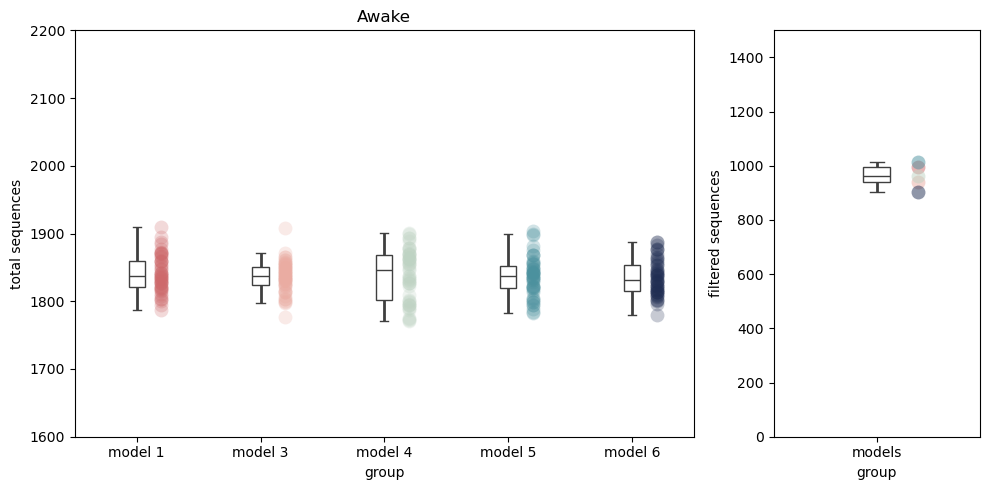

In [65]:
with open(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED4\latent_stability.pkl", "rb") as f:
    data = pickle.load(f)

awake_unfiltered = data['nonfiltered_latents_awake_df']
awake_filtered   = data['filtered_latents_awake_df']

# Setup figure with thinner right plot
# -----------------------------------------------------------
fig, (ax, ax1) = plt.subplots(
    1, 2, figsize=(10, 5),
    gridspec_kw={'width_ratios': [3, 1]}
)

# LEFT PLOT — unfiltered awake sequences
# -----------------------------------------------------------
# Colors for scatter points
colors = ['#CE696B', '#EAACA2', '#BED3C3', '#4B919E', '#202E53']

# Scatter
counter = 0
for c, i in awake_unfiltered.groupby('group'):
    ax.plot([counter + 0.2] * len(i),
            i['total sequences'].values,
            'o', alpha=0.25, color=colors[counter % len(colors)],
            markersize=10, markeredgewidth=0)
    counter +=1 

# Boxplot
sns.boxplot(
    y="total sequences", x="group", data=awake_unfiltered,
    width=.13, showcaps=True, showfliers=False,
    boxprops={'facecolor': 'none'}, whiskerprops={'linewidth': 2},
    ax=ax
)
ax.set_ylim(1600, 2200)
ax.set_title("Awake")

# RIGHT PLOT — filtered awake sequences
# -----------------------------------------------------------
df_filt = pd.DataFrame({
    "group": ["models"] * len(awake_filtered),
    "filtered sequences": awake_filtered
})

# Scatter
for i,item in enumerate(awake_filtered):
    ax1.plot(
    [0.2], item,
    'o', alpha=0.5, markersize=10, markeredgewidth=0,
    color= colors[i]
)

sns.boxplot(
    y="filtered sequences", x="group", data=df_filt,
    width=.13, showcaps=True, showfliers=False,
    boxprops={'facecolor': 'none'}, whiskerprops={'linewidth': 2},
    ax=ax1
)
ax1.set_ylim(0, 1500)
plt.tight_layout()

# figure F 

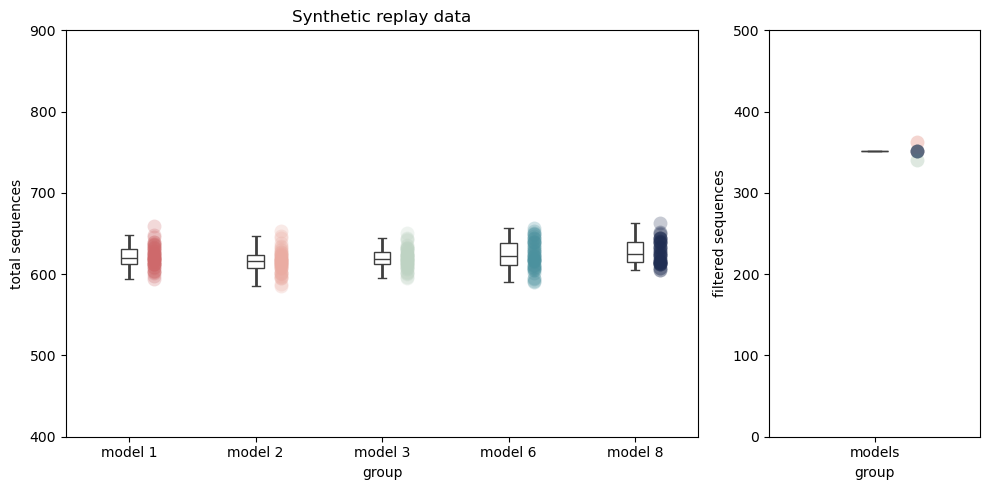

In [70]:
with open(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED4\latent_stability.pkl", "rb") as f:
    data = pickle.load(f)

synthetic_unfiltered = data['nonfiltered_latents_synthetic_df']
synthetic_filtered   = data['filtered_latents_synthetic_df']

# Setup figure with thinner right plot
# -----------------------------------------------------------
fig, (ax, ax1) = plt.subplots(
    1, 2, figsize=(10, 5),
    gridspec_kw={'width_ratios': [3, 1]}
)

# LEFT PLOT — unfiltered awake sequences
# -----------------------------------------------------------
# Colors for scatter points
colors = ['#CE696B', '#EAACA2', '#BED3C3', '#4B919E', '#202E53']

# Scatter
counter = 0
for c, i in synthetic_unfiltered.groupby('group'):
    ax.plot([counter + 0.2] * len(i),
            i['total sequences'].values,
            'o', alpha=0.25, color=colors[counter % len(colors)],
            markersize=10, markeredgewidth=0)
    counter +=1 

# Boxplot
sns.boxplot(
    y="total sequences", x="group", data=synthetic_unfiltered,
    width=.13, showcaps=True, showfliers=False,
    boxprops={'facecolor': 'none'}, whiskerprops={'linewidth': 2},
    ax=ax
)
ax.set_ylim(400, 900)
ax.set_title("Synthetic replay data")

# RIGHT PLOT — filtered awake sequences
# -----------------------------------------------------------
df_filt = pd.DataFrame({
    "group": ["models"] * len(synthetic_filtered),
    "filtered sequences": synthetic_filtered
})

# Scatter
for i,item in enumerate(synthetic_filtered):
    ax1.plot(
    [0.2], item,
    'o', alpha=0.5, markersize=10, markeredgewidth=0,
    color= colors[i]
)

sns.boxplot(
    y="filtered sequences", x="group", data=df_filt,
    width=.13, showcaps=True, showfliers=False,
    boxprops={'facecolor': 'none'}, whiskerprops={'linewidth': 2},
    ax=ax1
)
ax1.set_ylim(0, 500)
plt.tight_layout()

# figure G

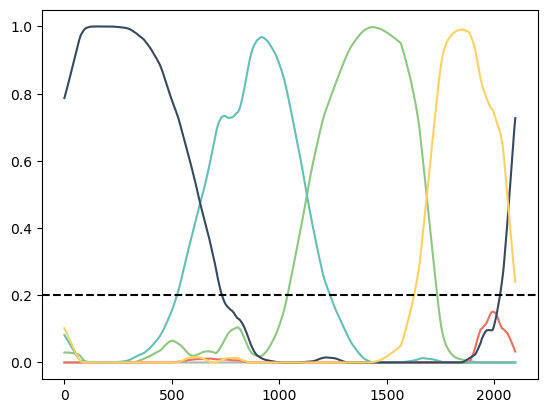

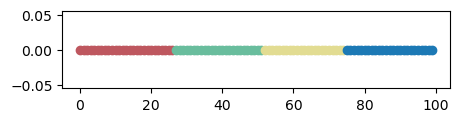

In [12]:
#file loading
# -----------------------------
PP_PATH = os.path.join(current_working_dir, "ppseq_output_awake")
DAT_PATH = os.path.join(current_working_dir, "example_mouse_data")

file = find_example_file(PP_PATH)
c_path = os.path.join(PP_PATH, file, "analysis_output", "reordered_recolored")

# Load data
with open(os.path.join(c_path, "colors"), "rb") as f:
    colors = pickle.load(f)
warped_x = np.load(os.path.join(c_path, "fixed_standard_space", "warped_x.npy"), allow_pickle=True)
smoothed_counts = np.load(os.path.join(c_path, "fixed_standard_space", "smoothed_counts.npy"), allow_pickle=True)
total_smoothed_counts = smoothed_counts.sum(axis=0)

# Plot smoothed motif activity
# -----------------------------
fig, ax = plt.subplots()
for i in range(6):
    ax.plot(
        convolve_movmean(smoothed_counts[i] / total_smoothed_counts, 100),
        color=colors[i + 1]
    )

threshold = 0.2
plt.axhline(threshold, color='k', linestyle='--')

# Identify threshold overlaps
# -----------------------------
overlap_positions = []
overlap_positions_standard_space = []
overlap_color = []

n_timepoints = smoothed_counts.shape[1]
linspace_idx = np.linspace(0, n_timepoints - 1, n_timepoints).astype(int)

for seq in range(6):
    # Points where motif explains >20% of activity
    over_thr_mask = (smoothed_counts[seq] / total_smoothed_counts) > threshold

    # Remove short bursts
    start_from_left = False
    idx = 0
    for is_over, grp in groupby(over_thr_mask):
        block = list(grp)
        block_len = len(block)

        if idx == 0 and is_over:
            start_from_left = True

        is_short = block_len < 10
        at_edge = idx + block_len >= len(over_thr_mask)

        if is_over and is_short:
            if (not at_edge) or (at_edge and not start_from_left):
                over_thr_mask[idx:idx + block_len] = False

        idx += block_len

    overlap_color.append(over_thr_mask)
    overlap_positions.append(list(linspace_idx[over_thr_mask]))

    # Convert to standard space coordinates
    overlap_positions_standard_space.append(
        list(linspace_idx[over_thr_mask] / len(over_thr_mask) * 100)
    )

# Compute dominant sequence per bin
# -----------------------------
v_smoothed = [
    convolve_movmean(smoothed_counts[i] / total_smoothed_counts, 100)
    for i in range(len(smoothed_counts))]
# Dominant motif at each timepoint
dominant = [np.argmax(bin_) + 1 for bin_ in conactinate_nth_items(v_smoothed)]
# Compress into 100 bins
compressed_100 = []
for i in range(100):
    mask = (warped_x >= i) & (warped_x <= i + 1)
    compressed_100.append(most_common(list(np.array(dominant)[mask])))

color_ = np.array(colors)[compressed_100]
# -----------------------------
new_color_order = [
    'spacer', '#BE575F', '#69BD9D', '#E2DC92',
    '#1C79B5', '#724F94', '#C6963E'
]
# Convert colors back into sequence IDs
seq_type = [colors.index(c) for c in color_]
# Merge short blocks and relabel
result = merge_short_blocks(seq_type, threshold=5)
relabeled_list = relabel_list(result)
final_colors = np.array(new_color_order)[relabeled_list]
# 1D visualization
# -----------------------------
fig, ax = plt.subplots(figsize=(5, 1))
for idx, col in enumerate(final_colors):
    ax.plot(idx, 0, 'o', color=col)

plt.show()
